In [1]:
import pandas as pd
import numpy as np
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import re

In [2]:
df = pd.read_csv('./bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


Distribution of news categories

/tmp/ipykernel_29338/3073674488.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='category', palette='viridis')


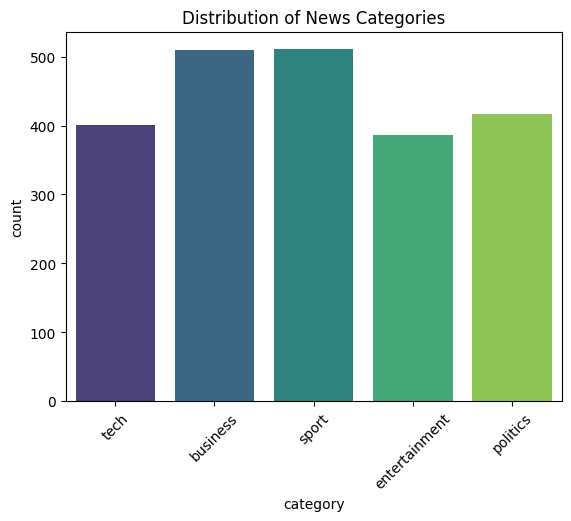

In [3]:
sns.countplot(data=df, x='category', palette='viridis')
plt.title("Distribution of News Categories")
plt.xticks(rotation=45)
plt.show()

Text Preprocessing

In [4]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert Text to lower
    text = text.lower()
    # delete punctuations
    punctuation_pattern = r'[^\w\s]'
    text = re.sub(punctuation_pattern, '', text)
    # toknize text
    tokens = nltk.word_tokenize(text)
    # delete stop words
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    # Stem words
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    # lemmatize words
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in stemmed_tokens]
    
    return " ".join(lemmatized_tokens)

df['preprocessed_text'] = df['text'].apply(preprocess_text)

df[['text', 'preprocessed_text']].head()

,text,preprocessed_text
0,tv future in the hands of viewers with home th...,tv futur hand viewer home theatr system plasma...
1,worldcom boss left books alone former worldc...,worldcom bos left book alon former worldcom bo...
2,tigers wary of farrell gamble leicester say ...,tiger wari farrel gambl leicest say rush make ...
3,yeading face newcastle in fa cup premiership s...,yead face newcastl fa cup premiership side new...
4,ocean s twelve raids box office ocean s twelve...,ocean twelv raid box offic ocean twelv crime c...


Word cloud

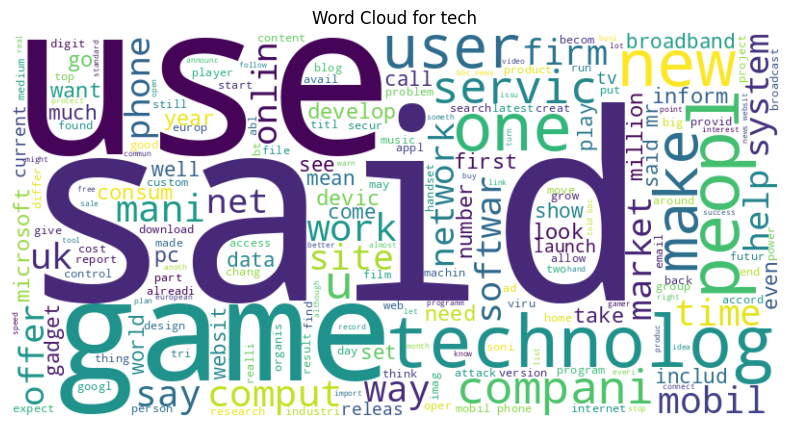

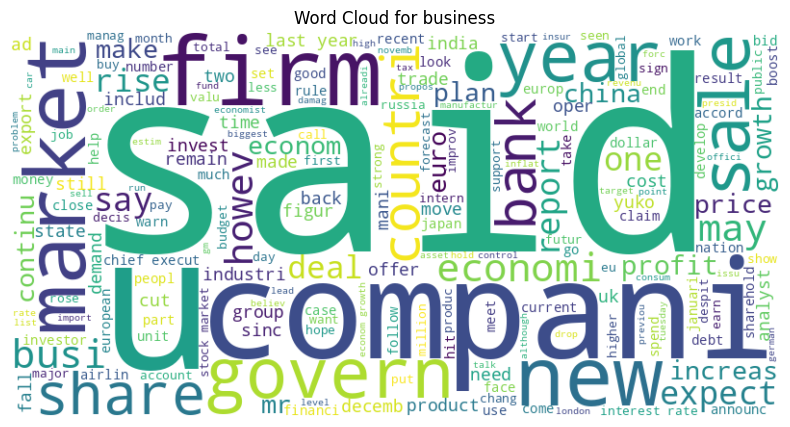

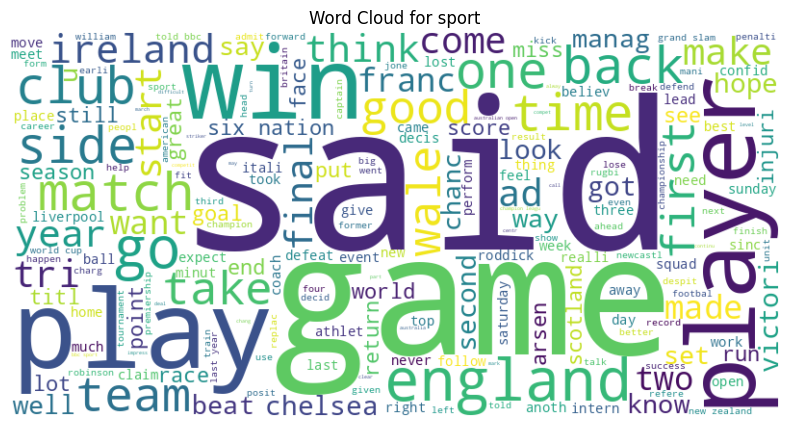

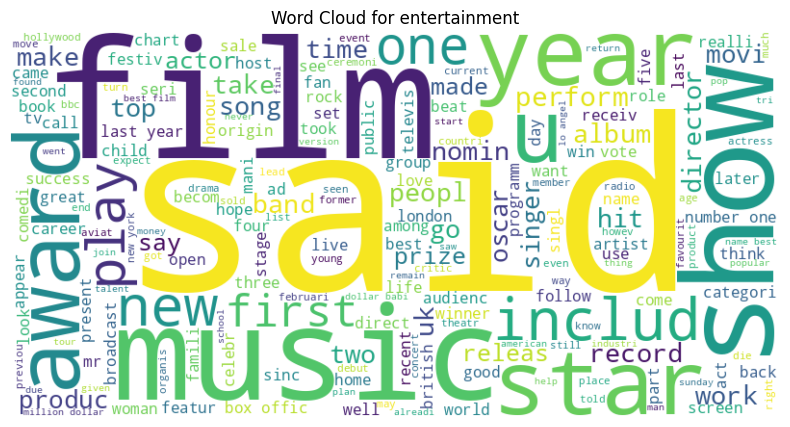

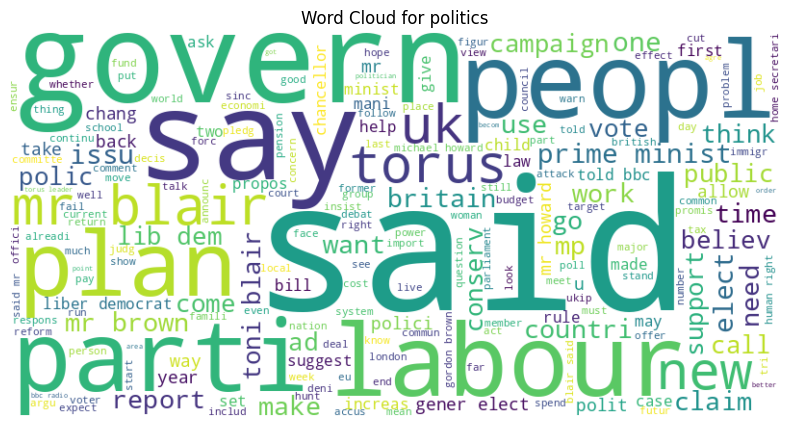

In [5]:
from wordcloud import WordCloud

for category in df['category'].unique():
    # Combine all preprocessed text for the category
    category_text = " ".join(df[df['category'] == category]['preprocessed_text'])
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(category_text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {category}")
    plt.axis('off')  # Turn off axes
    plt.show()


Word frequency analysis

/tmp/ipykernel_29338/2161838351.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=common_df, x='Frequency', y='Word', palette='plasma')


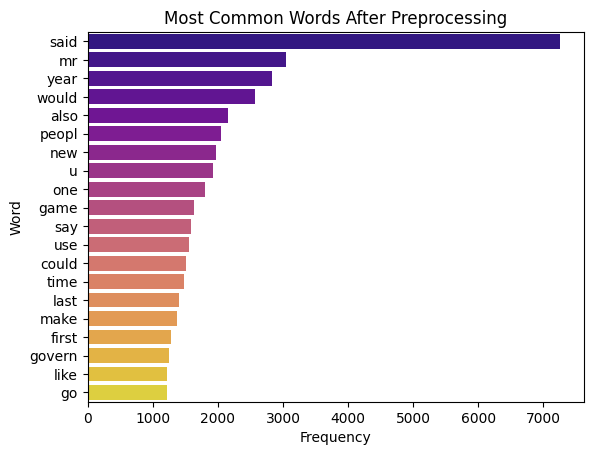

In [6]:
all_words = [word for text in df['preprocessed_text'] for word in text.split()]

word_freq = Counter(all_words)

most_common_words = word_freq.most_common(20)
common_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

sns.barplot(data=common_df, x='Frequency', y='Word', palette='plasma')
plt.title("Most Common Words After Preprocessing")
plt.show()

Vectorization using TF_IDF

In [7]:

tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(df["preprocessed_text"])

tfidf_matrix.shape

(2225, 23737)

/tmp/ipykernel_29338/459482898.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tfidf_sample, x='TF-IDF Score', y='Word', palette='cividis')


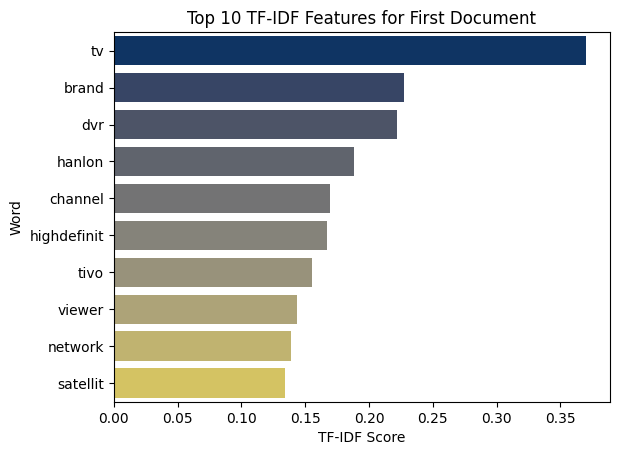

In [8]:
tfidf_sample = pd.DataFrame(tfidf_matrix[0].toarray().T, columns=["TF-IDF Score"])
tfidf_sample['Word'] = tfidf_vectorizer.get_feature_names_out()
tfidf_sample = tfidf_sample.sort_values(by="TF-IDF Score", ascending=False).head(10)

sns.barplot(data=tfidf_sample, x='TF-IDF Score', y='Word', palette='cividis')
plt.title("Top 10 TF-IDF Features for First Document")
plt.show()

Encoding Categorical Variables

In [9]:
label_encoder = LabelEncoder()

df['category_encoded'] = label_encoder.fit_transform(df["category"])

df[['category', 'category_encoded']].drop_duplicates().sort_values('category_encoded')

,category,category_encoded
1,business,0
4,entertainment,1
5,politics,2
2,sport,3
0,tech,4


Modeling with RandomForestClassifier

In [10]:
X = tfidf_matrix
y = df['category_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((1780, 23737), (445, 23737))

In [11]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Model evaluation by confusion matrix


Classification Report:
               precision    recall  f1-score   support

     business       0.90      0.95      0.92       101
entertainment       1.00      0.91      0.95        81
     politics       0.93      0.95      0.94        83
        sport       0.99      0.99      0.99        98
         tech       0.96      0.95      0.96        82

     accuracy                           0.95       445
    macro avg       0.96      0.95      0.95       445
 weighted avg       0.95      0.95      0.95       445



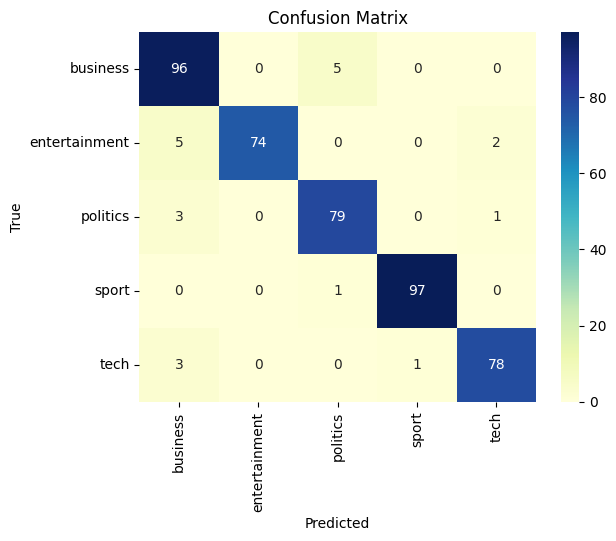

Overall Accuracy: 0.95


In [12]:
# Predict on the test data
y_pred = classifier.predict(X_test)

# Classification report to evaluate model performance
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix to visualize model performance
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.2f}")


In [13]:
df.head()

,category,text,preprocessed_text,category_encoded
0,tech,tv future in the hands of viewers with home th...,tv futur hand viewer home theatr system plasma...,4
1,business,worldcom boss left books alone former worldc...,worldcom bos left book alon former worldcom bo...,0
2,sport,tigers wary of farrell gamble leicester say ...,tiger wari farrel gambl leicest say rush make ...,3
3,sport,yeading face newcastle in fa cup premiership s...,yead face newcastl fa cup premiership side new...,3
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean twelv raid box offic ocean twelv crime c...,1
